The Augmented Lagrangian
$$
L_{\sigma}(c,b,u;\lambda)=\frac{1}{2}c^{\top}Kc+C\|u_+\|_0+\frac{\sigma}{2}\|u-\big({\mathbf 1}-{\rm diag}(y)K c-b*y-\frac{\boldsymbol{\lambda}}{\sigma}\big)\|^2-\frac{\|\boldsymbol{\lambda}\|^2}{2\sigma}.
$$

In [1]:
# coding=utf-8
#L01 Proximal Operator Prox_{gamma C||(.)_+||}(eta)=argmin_{v} C||(v)_+||_0+1/(2gamma)||v-eta||^2
def Prox(eta,threshold):
    eta[np.where(np.logical_and(eta>0,eta<=threshold))] = 0  #threshold=np.sqrt(2*gamma*C)
    return eta

In [2]:
#Packages
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from scipy import linalg
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import pairwise_kernels  
import time

In [3]:
#Dataset: Double Circles
#https://scikit-learn.org/0.19/modules/generated/sklearn.datasets.make_circles.html
from sklearn.datasets import  make_circles
random.seed(6)
X,Y=make_circles(n_samples=500,noise=0.1,factor=0.1,random_state=3)

In [4]:
from sklearn import preprocessing 
Y[np.where(Y==0)]=-1  #Transform label 0，1 to label -1，1
Standardscaler = preprocessing.StandardScaler() 
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
X = Standardscaler.fit_transform(X)

#Label noise  ratio r=0%，1%,5%,10%
index_labelnoise=random.sample(range(len(Y)),10) # 2*r%*500 percent of label noise
#print(index_labelnoise)
Y[index_labelnoise]=-Y[index_labelnoise]

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.4,random_state=33)
print('X train shape',X_train.shape)
print('X test shape',X_test.shape)

X train shape (300, 2)
X test shape (200, 2)


L01KSVMTrain

In [5]:
#L01KSVMTrain
start = time.time()
K = pairwise_kernels(X_train, Y=None, metric='rbf')  # ‘linear’, ‘poly’, ‘rbf’, ‘laplacian
y = y_train
m=np.shape(X_train)[0]

    
#Initialization
c = np.zeros(m)               #coefficients
b=0                           #b=1,-1 bias
u = np.random.random(m)       #loss
Lambda = np.random.random(m)  #Multipliers
max_iter=2000                  #Maximum iteration
beta=np.zeros(4)              #KKT error
tol=1e-3                      #KKT tolerance level 

#Best parameters obtained by Gridseach
C=2
sigma=2
iota=1          #learning_rate=iota*sigma
# acc=np.zeros(max_iter)

for i in range(max_iter): 
          
    #updating u
    u_k=np.ones(m)- np.multiply(y,np.dot(K,c))-b*y 
    eta=u_k- Lambda/sigma # eta=np.ones(m)- np.multiply(y,np.dot(K,c))-b*y #np.dot(np.dot(y_diag,K),c)=np.multiply(y,np.dot(K,c))    
    u = Prox(eta,2*C/sigma)   
            
    #updating c   
    xi = np.ones(m)-u- b*y-Lambda/sigma
    c = linalg.solve(K+np.eye(m)/sigma,np.multiply(y,xi))   #np.dot(y_diag,xi)=np.multiply(y,xi)
        
    #updating b
    r = np.ones(m)- u- np.multiply(y,np.dot(K,c))-Lambda/sigma
    b = np.dot(y.T,r)/m
    
    #updating Lambda 
    w = u + np.multiply(y,np.dot(K,c)) + b*y - np.ones(m) 
    index = np.where(u==0)[0]
    index_c= np.nonzero(u)[0]
    Lambda[index]=Lambda[index]+iota*sigma*w[index]      
    Lambda[index_c]=0
    
#     #Accuracy stopping rule
#     acc[i]=accuracy_score(np.sign(-np.dot(K,np.multiply(Lambda,y)) + b),y_train)
#     if np.logical_and(i>5,acc[i]>0.8):
#         if np.std(acc[i-3:i],ddof=1)<1e-3:
#             print('Accuracy is stable when i=',i+1)
#             break
    
    #KKT stopping rule
    beta[0]=np.linalg.norm(c+np.multiply(y,Lambda),2)/(1+np.linalg.norm(c,2))#c related to lambda；
    beta[1]=(np.abs(np.dot(y.T,Lambda)))/m  
    beta[2]=np.linalg.norm(w,2)/np.sqrt(m)  
    beta[3]=np.linalg.norm(u_k-u,2)/(1+np.linalg.norm(u,2)) 
    #print('KKT error beta',beta.T)
    if  np.amax(beta)<tol: 
        print('KKT condition (tolerance level=1e-4) is satisfied with iteration i:=',i+1)
        break  
        
end = time.time()
print('Program time of L01KSVM is:%ss'%(str(end-start)))

Program time of L01KSVM is:2.6263856887817383s


In [6]:
#Output Solutions of L01KSVM
#print('solution b',b)
#print('solution c tranpose',c[np.nonzero(u)[0]].T)
#print('solution u tranpose',u[np.nonzero(u)[0]].T)
#print('solution Lambda:\n',Lambda[np.nonzero(Lambda)[0]].T)
#print('Lambda:\n',Lambda.shape)

In [7]:
#L01KSVM Accuracy 
print('Train Accuracy:\n', accuracy_score(np.sign(-np.dot(K,np.multiply(Lambda,y)) + b),y_train))
K_test = pairwise_kernels(X_test,X_train, metric='rbf') 
print('Test Accuracy:\n', accuracy_score(np.sign(-np.dot(K_test,np.multiply(Lambda,y) ) + b),y_test))

Train Accuracy:
 0.9833333333333333
Test Accuracy:
 0.975


Gaussian Kernel SVM with Squared Hinge Loss

In [8]:
#Standard Gaussian Kernel SVM with Squared Hinge Loss
#Best parameter obtained by Gridsearch
start1 = time.time()
#if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,
clf=SVC(C=4,kernel='rbf').fit(X_train,y_train)  #default='squared_hinge'
end1 = time.time()
#print('Indices of support vectors for HingeKSVM:\n',clf.support_)
support_vectors =clf.support_vectors_  #Support vectors.
#Decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
decision_function = clf.decision_function(X_train)
support_vector_indices_canonical = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
#print('Total number of SV on canonical hyperplane:',support_vector_indices_canonical.shape[0])

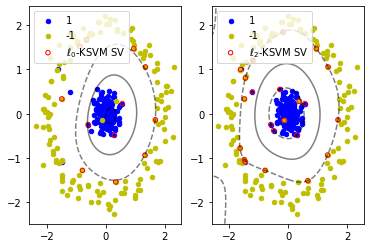

In [9]:
# ##L01KSVM:plot the decision function 
plt.subplot(1,2,1)
#plt.rcParams['figure.dpi'] = 200 #分辨率
plt.rcParams['font.size'] = '10'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (9.0, 4.0) 
#plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.Paired)
idx_1 = np.where(y_train==1)
p1 = plt.scatter(X_train[idx_1,0], X_train[idx_1,1], marker = 'o', color = 'b', label='1', s = 20)
idx_2 = np.where(y_train==-1)
p2 = plt.scatter(X_train[idx_2,0], X_train[idx_2,1], marker = 'o', color = 'y', label='-1', s = 20)


ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 50))
K_classifier = pairwise_kernels(np.c_[xx.ravel(), yy.ravel()],X_train, metric='rbf') 
Y_classifiervalue=-np.dot(K_classifier,np.multiply(Lambda,y) ) + b  
Z=Y_classifiervalue.reshape(xx.shape)

plt.contour(xx,yy,Z,colors='k',levels=[-1, 0, 1], alpha=0.5,linestyles=['--', '-', '--'])
index_sv=np.nonzero(Lambda)[0] 
sv_L01Loss = X_train[index_sv]  #support vectors for L01KSVM
plt.scatter(sv_L01Loss[:, 0],sv_L01Loss[:, 1],s=20,linewidth=1,facecolors='none',edgecolors='r',label='$\ell_0$-KSVM SV')
plt.legend(loc = 'upper left')
#plt.title('L01KSVM',fontsize=10)
#plt.savefig('L01KSVM__DoubleMoons.png', bbox_inches='tight')

# #HingeKSVM:plot the decision function
plt.subplot(1,2,2)
plt.rcParams['figure.dpi'] = 300 #分辨率
plt.rcParams['font.size'] = '10'
#plt.rcParams['figure.figsize'] = (8.0, 4.0) 
#plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.Paired)
idx_1 = np.where(y_train==1)
p1 = plt.scatter(X_train[idx_1,0], X_train[idx_1,1], marker = 'o', color = 'b', label='1', s = 20)
idx_2 = np.where(y_train==-1)
p2 = plt.scatter(X_train[idx_2,0], X_train[idx_2,1], marker = 'o', color = 'y', label='-1', s = 20)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx,yy,Z,colors='k',levels=[-1, 0, 1], alpha=0.5,linestyles=['--', '-', '--'])
plt.scatter(support_vectors[:, 0],support_vectors[:, 1],s=20,linewidth=1,facecolors='none',edgecolors='r',label='$\ell_2$-KSVM SV')
plt.legend(loc = 'upper left')
#plt.title('SquaredHingeKSVM',fontsize=10)
plt.savefig('KSVM_DoubleCircleLabel1_500.png', bbox_inches='tight')

In [10]:
#Summary
#L01KSVM 
print({'C':C,'sigma':sigma,'iota':iota})
print('Threshold',np.sqrt((2*C)/sigma))
print('Iteration',i+1)
print('Program time of L01KSVM is:%ss'%(str(end-start)))


#dataset
print('Number of Training Data',m)
print('Number of Testing Data',y_test.shape[0])
#Accuracy
print('Train Accuracy of L01KSVM:',accuracy_score(np.sign(-np.dot(K,np.multiply(Lambda,y)) + b),y_train))
print('Test Accuracy of  L01KSVM:',accuracy_score(np.sign(-np.dot(K_test,np.multiply(Lambda,y) ) + b),y_test))
print('Train accuracy of HingeKSVM:',clf.score(X_train,y_train))
print('Test accuracy of HingeKSVM:',clf.score(X_test,y_test))
#Number of Support Vectors
print('Number of support vectors for L01KSVM',len(index_sv))  
print('Number of support vectors for HingeKSVM:',np.sum(clf.n_support_))
#Indices
print('Indices of support vectors for L01KSVM:\n',index_sv)
#print('Indices of support vectors for HingeKSVM:\n',clf.support_)
#Dual Coefficients
print('Lambda with nonzero elements for L01KSVM:\n',Lambda[np.nonzero(Lambda)])
print('Dual coefficients of the support vector in the decision function:\n',clf.dual_coef_)
#Computation Time
print('Computation Time for L01SVM',end-start)
print('Computation Time for HingeKSVM',end1-start1)

{'C': 2, 'sigma': 2, 'iota': 1}
Threshold 1.4142135623730951
Iteration 2000
Program time of L01KSVM is:2.6263856887817383s
Number of Training Data 300
Number of Testing Data 200
Train Accuracy of L01KSVM: 0.9833333333333333
Test Accuracy of  L01KSVM: 0.975
Train accuracy of HingeKSVM: 0.9833333333333333
Test accuracy of HingeKSVM: 0.975
Number of support vectors for L01KSVM 12
Number of support vectors for HingeKSVM: 22
Indices of support vectors for L01KSVM:
 [ 54  63  86 129 165 217 223 242 247 254 259 289]
Lambda with nonzero elements for L01KSVM:
 [-0.6466577  -0.56642963 -2.76459526 -1.5225472  -1.43722019 -0.1413476
 -0.37543643  0.02000543 -0.45388052 -0.25337687 -0.08238455 -2.74176272]
Dual coefficients of the support vector in the decision function:
 [[-0.00867317 -0.51143035 -1.19574682 -2.78276348 -1.74003388 -4.
  -4.         -3.64994952 -0.05076357 -0.24400439 -2.92671862 -0.22260676
  -0.83223441 -4.          0.43582256  4.          4.          4.
   2.78210362  4.      

Numerical Results

In [11]:
#m=500,r=0%,  {'C': 8, 'sigma': 1, 'iota': 1}
# Threshold 4.0
# KKT condition (tolerance level=1e-3) is satisfied with iteration i:= 442
# Program time of L01KSVM is:0.6464798450469971s
# Number of Training Data 300
# Number of Testing Data 200
# Train Accuracy of L01KSVM: 1.0
# Test Accuracy of  L01KSVM: 1.0
# Train accuracy of HingeKSVM: 1.0
# Test accuracy of HingeKSVM: 1.0
# Number of support vectors for L01KSVM 11
# Number of support vectors for HingeKSVM: 12
# Indices of support vectors for L01KSVM:
#  [ 20  54  63  86 129 142 153 165 247 254 259]
# Indices of support vectors for HingeKSVM:
#  [ 20  54  63 142 165 217 254 259  86 129 153 247]
# Lambda with nonzero elements for L01KSVM:
#  [-0.10340499 -0.3059651  -0.43836099 -3.55925659 -0.84428481 -2.82585411
#  -1.4396141  -1.72342906 -0.09843126 -0.14866908 -0.39689   ]
# Dual coefficients of the support vector in the decision function:
#  [[-0.14253026 -0.32005985 -0.436511   -2.67912628 -1.62669788 -0.03461247
#   -0.15944648 -0.35387487  3.31153603  0.82238795  1.42495975  0.19397536]]
# Computation Time for L01SVM 0.6464798450469971
# Computation Time for HingeKSVM 0.0016734600067138672

In [12]:
#m=1000, r=0%, {'C': 8, 'sigma': 1, 'iota': 1}
# {'C': 8, 'sigma': 1, 'iota': 1}
# Threshold 4.0
# KKT condition (tolerance level=1e-3) is satisfied with iteration i:= 272
# Program time of L01KSVM is:0.4473695755004883s
# Number of Training Data 300
# Number of Testing Data 200
# Train Accuracy of L01KSVM: 1.0
# Test Accuracy of  L01KSVM: 1.0
# Train accuracy of HingeKSVM: 1.0
# Test accuracy of HingeKSVM: 1.0
# Number of support vectors for L01KSVM 11
# Number of support vectors for HingeKSVM: 12
# Indices of support vectors for L01KSVM:
#  [ 20  54  63  86 129 142 153 165 247 254 259]
# Indices of support vectors for HingeKSVM:
#  [ 20  54  63 142 165 217 254 259  86 129 153 247]
# Lambda with nonzero elements for L01KSVM:
#  [-0.11627075 -0.31866652 -0.45229589 -3.5783094  -0.86007676 -2.8419512
#  -1.45666328 -1.73864293 -0.11233366 -0.15156592 -0.3964633 ]
# Dual coefficients of the support vector in the decision function:
#  [[-0.14253026 -0.32005985 -0.436511   -2.67912628 -1.62669788 -0.03461247
#   -0.15944648 -0.35387487  3.31153603  0.82238795  1.42495975  0.19397536]]
# Computation Time for L01SVM 0.4473695755004883
# Computation Time for HingeKSVM 0.0009789466857910156

In [13]:
# m=1500, r=0%
# {'C': 8, 'sigma': 1, 'iota': 1}
# Threshold 4.0
# KKT condition (tolerance level=1e-3) is satisfied with iteration i:= 655
# Program time of L01KSVM is:19.68915891647339s
# Number of Training Data 900
# Number of Testing Data 600
# Train Accuracy of L01KSVM: 1.0
# Test Accuracy of  L01KSVM: 1.0
# Train accuracy of HingeKSVM: 1.0
# Test accuracy of HingeKSVM: 1.0
# Number of support vectors for L01KSVM 9
# Number of support vectors for HingeKSVM: 9
# Indices of support vectors for L01KSVM:
#  [118 207 212 224 301 372 537 690 761]
# Indices of support vectors for HingeKSVM:
#  [207 212 224 372 537 761 118 301 690]
# Lambda with nonzero elements for L01KSVM:
#  [-0.88068719 -0.30197128 -2.71337533 -1.26707506 -4.6538237  -3.16361019
#  -1.27079958 -4.04572559 -0.88600823]
# Dual coefficients of the support vector in the decision function:
#  [[-0.28956386 -2.60942492 -1.21335517 -3.04524089 -1.20693217 -0.83974026
#    0.85789598  4.46119227  3.88516903]]
# Computation Time for L01SVM 19.68915891647339
# Computation Time for HingeKSVM 0.0018148422241210938

In [14]:
#m=500,r=1%
# {'C': 1, 'sigma': 1, 'iota': 1}
# Threshold 1.4142135623730951
# KKT condition (tolerance level=1e-3) is satisfied with iteration i:= 2000
# Program time of L01KSVM is:2.6302642822265625s
# Number of Training Data 300
# Number of Testing Data 200
# Train Accuracy of L01KSVM: 0.9833333333333333
# Test Accuracy of  L01KSVM: 0.975
# Train accuracy of HingeKSVM: 0.9833333333333333
# Test accuracy of HingeKSVM: 0.975
# Number of support vectors for L01KSVM 16
# Number of support vectors for HingeKSVM: 19
# Indices of support vectors for L01KSVM:
#  [ 20  54  63  86 129 142 143 153 165 217 223 247 254 258 259 289]
# Indices of support vectors for HingeKSVM:
#  [ 12  54  63  71 138 139 165 176 254 272 289 129 130 142 143 153 186 189
#  247]
# Lambda with nonzero elements for L01KSVM:
#  [-0.08217379 -0.6840095  -0.64881246 -1.31273895 -1.63525365 -1.37274024
#  -1.12381606 -0.11731907 -1.58164358 -0.18016203 -0.17625117 -0.59330207
#  -0.30672732 -0.57224563 -0.12376651 -1.52853848]
# Dual coefficients of the support vector in the decision function:
#  [[-15.24673874  -1.37919524  -1.93441014  -6.72140243 -16.
#   -16.          -5.66679646  -0.03421321  -1.00284963 -13.40374093
#   -12.74054917  16.           0.41815251  16.          11.44848158
#     7.48457172  16.          16.           6.77869015]]
# Computation Time for L01SVM 2.6302642822265625
# Computation Time for HingeKSVM 0.0020046234130859375

In [15]:
# m=500,r=5%
# {'C': 0.5, 'sigma': 1, 'iota': 1}
# Threshold 1.0
# KKT condition (tolerance level=1e-3) is satisfied with iteration i:= 2000
# Program time of L01KSVM is:2.966860771179199s
# Number of Training Data 300
# Number of Testing Data 200
# Train Accuracy of L01KSVM: 0.9066666666666666
# Test Accuracy of  L01KSVM: 0.89
# Train accuracy of HingeKSVM: 0.9133333333333333
# Test accuracy of HingeKSVM: 0.89
# Number of support vectors for L01KSVM 19
# Number of support vectors for HingeKSVM: 69
# Indices of support vectors for L01KSVM:
#  [ 20  54  86 109 127 129 130 143 162 169 176 219 223 241 247 254 257 258
#  259]
# Indices of support vectors for HingeKSVM:
#  [  4  10  12  16  27  41  51  52  62  73  87  91  93 122 131 138 139 153
#  167 169 170 176 182 192 205 210 219 223 228 242 254 258 272 278 279 294
#  299   5   8  33  46  49  63  66  71  96 109 118 125 129 130 134 142 154
#  165 186 189 199 200 202 217 224 247 249 263 266 269 282 289]
# Lambda with nonzero elements for L01KSVM:
#  [-0.08798393 -0.23532554 -0.69490462 -0.00828769 -0.54968461 -0.56915449
#  -0.67325482 -0.84647893 -0.08355899 -0.46773535 -0.38486442 -0.39269254
#  -0.16928621 -0.27346522 -0.51894173 -0.58407431 -0.61916091 -0.70712165
#  -0.42301158]
# Dual coefficients of the support vector in the decision function:
#  [[-32.         -12.76383899 -32.          -7.80193565 -32.
#    -6.8312016  -32.          -4.49638132 -32.          -1.06084585
#    -6.64966067 -32.         -32.         -22.27350852 -24.87751317
#   -32.         -32.         -32.         -22.80481981 -32.
#   -32.         -29.06899669 -22.4315488  -32.          -0.5855417
#   -32.         -16.26361549 -10.56622141 -32.         -32.
#   -32.         -32.         -32.         -21.82355771 -20.09927795
#   -32.         -32.          32.          32.          32.
#    32.          32.          32.          32.          32.
#    32.          32.          32.           8.83922846  32.
#    20.7788339   32.          32.          32.          32.
#    32.          32.          11.38721475  32.          32.
#    32.          32.          20.40554842  32.          12.96010797
#    19.07432952   9.68015758  31.27304473  32.        ]]
# Computation Time for L01SVM 2.966860771179199
# Computation Time for HingeKSVM 0.007978677749633789


# {'C': 1, 'sigma': 2, 'iota': 1}  C=4
# Threshold 1.0
# KKT condition (tolerance level=1e-3) is satisfied with iteration i:= 2000
# Program time of L01KSVM is:2.6771905422210693s
# Number of Training Data 300
# Number of Testing Data 200
# Train Accuracy of L01KSVM: 0.9066666666666666
# Test Accuracy of  L01KSVM: 0.89
# Train accuracy of HingeKSVM: 0.9066666666666666
# Test accuracy of HingeKSVM: 0.89
# Number of support vectors for L01KSVM 16
# Number of support vectors for HingeKSVM: 72
# Indices of support vectors for L01KSVM:
#  [ 20  33  54  86 129 143 162 169 176 219 223 241 247 254 258 259]
# Lambda with nonzero elements for L01KSVM:
#  [-0.14739131 -0.03173462 -0.25395056 -0.74089319 -1.08570193 -0.74750297
#  -0.10513464 -0.44573185 -0.45028017 -0.43213639 -0.01332972 -0.20869086
#  -0.6748906  -0.58281432 -0.61928766 -0.23016096]
# Dual coefficients of the support vector in the decision function:
#  [[-4.         -1.33972426 -4.         -1.04242115 -4.         -2.456187
#   -0.6011386  -4.         -4.         -4.         -3.37926805 -4.
#   -4.         -2.73831254 -4.         -4.         -4.         -4.
#   -0.96970726 -4.         -4.         -3.24152269 -1.00018479 -0.09162599
#   -4.         -2.46673947 -4.         -3.84135153 -1.18954516 -4.
#   -2.05460841 -4.         -4.         -4.         -4.         -4.
#   -1.24631669 -0.61057147 -4.          4.          4.          4.
#    4.          4.          4.          4.          4.          4.
#    1.51343726  4.          4.          4.          4.          0.23437967
#    4.          4.          4.          4.          4.          4.
#    1.05627337  4.          4.          4.          4.          4.
#    4.          4.          4.          1.46513476  4.          4.        ]]
# Computation Time for L01SVM 2.6771905422210693
# Computation Time for HingeKSVM 0.001973867416381836

In [16]:
#m=500, r=10%, {'C': 1, 'sigma': 1, 'iota': 1}
# Threshold 1.0
# KKT condition (tolerance level=1e-3) is satisfied with iteration i:= 2000
# Program time of L01KSVM is:2.7884082794189453s
# Number of Training Data 300
# Number of Testing Data 200
# Train Accuracy of L01KSVM: 0.7933333333333333
# Test Accuracy of  L01KSVM: 0.81
# Train accuracy of HingeKSVM: 0.7966666666666666
# Test accuracy of HingeKSVM: 0.81
# Number of support vectors for L01KSVM 17
# Number of support vectors for HingeKSVM: 143
# Indices of support vectors for L01KSVM:
#  [ 12  20  22  54  86 109 127 129 130 143 162 169 176 219 241 254 259]
# Indices of support vectors for HingeKSVM:
#  [  2   3   4   9  10  12  16  18  20  27  30  33  41  49  51  52  54  57
#   61  62  72  81  83  87  91  93  99 112 115 121 122 131 136 138 139 144
#  147 153 155 160 162 166 169 170 176 180 188 191 192 195 196 205 215 218
#  219 223 225 228 230 238 239 242 243 247 253 254 259 263 272 276 278 279
#  286 287 294 299   5   8  14  17  19  22  23  26  34  35  46  59  60  63
#   64  65  66  68  71  73  76  77  85  86  96 105 109 116 118 124 125 126
#  127 129 130 134 142 143 145 149 150 152 154 159 161 165 174 186 189 200
#  202 208 210 217 221 236 237 249 258 260 264 265 266 281 289 290 291]
# Lambda with nonzero elements for L01KSVM:
#  [-0.75530818 -0.1604753  -0.03926724 -0.37340951 -1.74011759 -0.02660368
#  -0.21359626 -0.69204007 -0.46843335 -0.58859427 -0.04391684 -0.70542435
#  -0.28784845 -0.33746751 -0.49759147 -0.60743444 -0.33744138]
# Dual coefficients of the support vector in the decision function:
#  [[ -6.14025401 -12.62074731 -16.          -4.79701442 -16.
#   -16.         -16.         -12.02577998  -0.75266631 -16.
#   -16.         -16.          -4.07517054 -16.         -16.
#   -16.         -12.71701475 -16.          -0.48805092 -16.
#   -16.          -2.65645568 -10.04592521 -16.         -16.
#   -16.         -16.         -16.          -8.97781255 -16.
#   -15.55303475 -13.82805592  -8.47669928 -16.         -16.
#   -16.         -16.         -16.         -16.         -16.
#    -4.18699915 -16.         -16.         -16.          -9.55199441
#    -7.4241367  -16.          -2.14131792 -16.         -16.
#   -16.          -2.87147569 -16.         -16.         -16.
#   -16.         -16.         -16.         -15.597092   -16.
#    -1.58779261  -4.52186821  -5.93098642 -16.         -16.
#   -16.         -15.21022185 -16.         -16.         -16.
#   -16.         -16.         -16.         -16.          -9.50816217
#   -16.          16.          16.          16.          16.
#    16.          16.          16.          16.          16.
#     1.71516025  16.          16.           3.03982785  16.
#    16.          16.          16.           8.08517592  16.
#    16.          16.           7.1569002   16.          13.35035044
#    16.          16.          16.          16.          16.
#    16.          16.          16.          16.          16.
#    16.          16.          16.          16.          16.
#    12.29057022  16.          16.          16.          16.
#    16.          16.          16.          16.          16.
#    16.          16.          16.          16.          16.
#    16.          16.          10.5596151   16.          16.
#     9.24594918  16.          16.          16.          14.24317961
#    16.          16.          16.        ]]
# Computation Time for L01SVM 2.7884082794189453
# Computation Time for HingeKSVM 0.009627103805541992


# {'C': 1, 'sigma': 2, 'iota': 1}
# Threshold 1.0
# KKT condition (tolerance level=1e-3) is satisfied with iteration i:= 2000
# Program time of L01KSVM is:3.865128517150879s
# Number of Training Data 300
# Number of Testing Data 200
# Train Accuracy of L01KSVM: 0.7933333333333333
# Test Accuracy of  L01KSVM: 0.81
# Train accuracy of HingeKSVM: 0.7933333333333333
# Test accuracy of HingeKSVM: 0.81
# Number of support vectors for L01KSVM 17
# Number of support vectors for HingeKSVM: 143
# Indices of support vectors for L01KSVM:
#  [ 12  20  22  54  86 109 127 129 130 143 162 169 176 219 241 254 259]
# Lambda with nonzero elements for L01KSVM:
#  [-0.76900226 -0.1560634  -0.08850126 -0.33304477 -1.67209566 -0.07719272
#  -0.24902495 -1.3190895  -0.55550621 -0.52328633 -0.03254644 -0.72182161
#  -0.29447056 -0.35765513 -0.50706317 -0.55555007 -0.31651726]
# Dual coefficients of the support vector in the decision function:
#  [[-1.91609166 -0.85900134 -4.         -4.         -4.         -4.
#   -2.32088365 -2.28775665 -4.         -4.         -4.         -0.18586253
#   -0.04204753 -4.         -4.         -4.         -4.         -4.
#   -4.         -0.89799751 -0.50291444 -4.         -4.         -0.58497442
#   -4.         -4.         -4.         -4.         -0.31782536 -4.
#   -3.60970123 -4.         -0.3903598  -4.         -4.         -4.
#   -4.         -4.         -4.         -4.         -4.         -1.56612232
#   -4.         -4.         -4.         -3.22449375 -3.30461129 -1.86909953
#   -1.44844121 -3.5674615  -1.23172911 -4.         -4.         -4.
#   -4.         -4.         -4.         -4.         -4.         -4.
#   -4.         -4.         -0.30484721 -4.         -4.         -4.
#   -4.         -4.         -4.         -4.         -4.         -4.
#   -4.         -4.         -4.         -4.         -4.          4.
#    1.13938314  4.          4.          4.          4.          4.
#    4.          4.          4.          4.          4.          4.
#    4.          4.          4.          4.          4.          4.
#    4.          4.          4.          4.          4.          4.
#    4.          4.          4.          4.          4.          4.
#    4.          4.          4.          4.          4.          4.
#    4.          4.          4.          4.          4.          4.
#    4.          4.          4.          4.          4.          4.
#    4.          4.          4.          4.          4.          3.78871923
#    4.          4.          4.          4.          4.          4.
#    2.16415249  3.33996718  4.          4.          4.        ]]
# Computation Time for L01SVM 3.865128517150879
# Computation Time for HingeKSVM 0.003907918930053711

In [17]:
# m=500, r=15%
# {'C': 0.5, 'sigma': 1, 'iota': 1}
# Threshold 1.0
# KKT condition (tolerance level=1e-3) is satisfied with iteration i:= 2000
# Program time of L01KSVM is:2.69598388671875s
# Number of Training Data 300
# Number of Testing Data 200
# Train Accuracy of L01KSVM: 0.71
# Test Accuracy of  L01KSVM: 0.685
# Train accuracy of HingeKSVM: 0.7133333333333334
# Test accuracy of HingeKSVM: 0.685
# Number of support vectors for L01KSVM 17
# Number of support vectors for HingeKSVM: 190
# Indices of support vectors for L01KSVM:
#  [ 12  20  22  54  86 127 129 143 162 169 176 219 223 241 254 257 259]
# Indices of support vectors for HingeKSVM:
#  [  2   4   9  11  12  13  16  18  20  27  30  32  33  41  49  51  52  53
#   54  57  60  62  72  74  79  80  81  83  87  88  91  93  97  99 112 121
#  122 130 131 136 137 138 139 144 147 148 151 153 155 156 160 162 166 167
#  169 170 172 174 176 180 188 191 192 195 196 207 211 213 214 215 218 219
#  220 223 225 226 228 229 230 234 238 239 240 242 243 246 247 253 254 259
#  263 272 276 278 279 286 287 294 297 299   3   5   8  10  14  15  17  19
#   22  23  26  31  34  37  38  44  46  63  64  65  66  70  71  73  76  77
#   84  85  86  95  96  98 105 107 108 109 110 116 118 124 125 126 127 129
#  132 134 142 143 145 150 152 154 157 161 164 165 177 182 185 186 189 198
#  202 206 210 212 216 217 221 222 232 236 237 244 249 258 264 265 266 268
#  270 271 273 281 284 288 289 290 291 296]
# Lambda with nonzero elements for L01KSVM:
#  [-0.74313341 -0.0920161  -0.61409346 -0.26823862 -0.55050814 -0.92018661
#  -0.44812215 -0.70762122 -0.11090029 -0.44874469 -0.38217692 -0.38015298
#  -0.12359526 -0.29753081 -0.63420037 -0.86135138 -0.32107411]
# Dual coefficients of the support vector in the decision function:
#  [[-16.         -16.         -16.         -16.         -16.
#   -16.         -16.         -14.1103394   -9.09358226 -16.
#   -16.         -16.         -16.         -12.4244754  -16.
#   -16.          -2.99216868 -16.         -16.         -16.
#   -16.         -16.         -16.         -16.         -16.
#   -16.          -1.7839767  -10.69216342 -16.         -16.
#   -16.         -16.          -2.81679283 -16.         -16.
#   -16.         -15.01256967 -16.          -9.55226586  -9.49480969
#    -8.68747753 -16.         -16.         -16.         -16.
#   -16.         -16.         -16.         -16.         -16.
#   -16.         -16.         -16.          -5.07766953 -16.
#   -16.          -2.14068994 -16.         -16.         -16.
#   -16.         -16.         -16.         -16.         -16.
#   -16.         -16.          -7.64462028 -10.15736291 -16.
#   -16.         -16.         -16.         -16.         -16.
#   -16.         -16.          -5.52530291  -8.43597089  -1.01135028
#   -16.          -4.73916047 -16.          -6.67486397 -16.
#    -4.48484985 -16.         -16.         -16.         -16.
#   -16.          -8.82933829 -16.         -16.         -16.
#   -16.         -16.         -16.         -16.         -16.
#    16.          16.          16.          16.          16.
#    16.          16.          16.          16.          16.
#    16.          16.          16.          16.          16.
#    14.96506838  16.          16.          16.          16.
#    16.          16.          16.          16.          16.
#    16.          16.          16.          16.          16.
#    16.           7.6554281   16.          16.          16.
#    16.          15.51617723  16.          16.          16.
#    16.          16.          16.          16.          16.
#    16.          16.          16.          16.          16.
#    16.          16.          16.          16.           1.44615123
#    16.          14.14118602  16.          16.          16.
#    16.          16.          16.          16.          16.
#    16.          16.          16.          16.          16.
#    16.          16.          16.          16.          16.
#    16.          16.          16.          16.          16.
#    11.84729514  15.81049467  16.          16.          16.
#    16.          16.          16.          16.          16.        ]]
# Computation Time for L01SVM 2.69598388671875
# Computation Time for HingeKSVM 0.009029626846313477